# Introduction / Problem Statement

<p> 
New York city is the most populous city in the United States. With an estimated 2019 population of 8.5 million distributed over about 302.6 square miles, New York City is also the most densely populated major city in the United States. It is a city that is second to none in terms of immigration, racial diversity, cultural diversity among other things  

Of the many cuisines of New York City, turkish cuisine has gained popularity over the past few years. The history of Turkish restaurants in Manhattan goes back to the years when Turkish immigrants started working at Armenian restaurants.

With its immense mediterranean population, it was only natural that Turkish cuisine would gain populrity, and New York City, which has the most restaurants in the world, has ONLY 23 Turkish restaurants on the island of Manhattan, thus making it one of the most lucrative cusines for a restaurateur to invest in. 

My project will explore the best locations for Turkish restaurants throughout the city of New York. New York is the most diverse city in the world (800 languages are spoken in New York) and has a long tradition of different ethnical restaurants. However, as with any business, opening a new restaurant requires serious considerations and is more complicated than it seems. In particular, the location of the restaurant is one of the most important factors that will determine its fate. 

So this is an attempt to answer business problems such as “Where in new york should a restaurateur/entrepreneur open a Turkish Restaurant?” and “Where can one find a turkish restaurant in New York City?” 
</p>


# Data for my analysis and process steps

<p> 
In order to answer the above questions, data on New York City neighborhoods, boroughs (to include boundaries, latitude, longitude) will be obtained from the data source: https://cocl.us/new_york_dataset. 

Data will be scrubbed and loaded into a dataframe.

All data related to locations/venues of Turkish restaurants will be obtained via the FourSquare API. 

Ratings, tips, and likes by users will be counted and added to the dataframe and sorted based on rankings. 

Finally, we shall use Folium as out data visualization tool.
</p>

### We shall now import all libraries needed for our data exploration

In [1]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests 
from bs4 import BeautifulSoup
import os
import folium 
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

In [2]:
# My Foursquare Credentials and Version

CLIENT_ID = 'VMR0FI3V1RFQBSJWFK2ZE3RJWDN5J3DE1FSDCXPBWFVU3OZR' 
CLIENT_SECRET = 'KFCECQCHGZC5NHBD3YWDJ4VVLRAU4KMGJBPSVKDGX3FDRWYR' 
VERSION = '20180605' 

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

### Now that we have the code for ETL of data in place, let's start our data analysis and exploration

In [4]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
# Number of neighborhoods in New York

ny_data.shape

(306, 4)

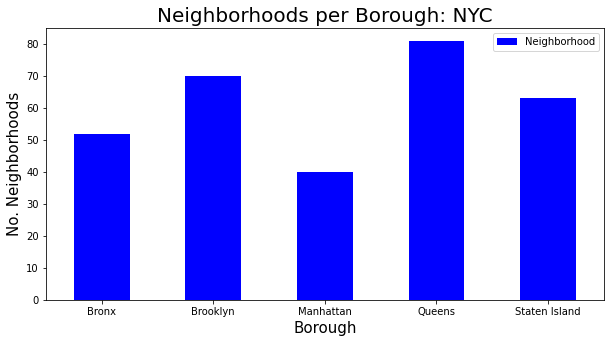

In [6]:
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [8]:
# queens has most neighborhoods
# prepare neighborhood list that contains Turkish restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
turkish_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    turkish_restaurants=venues[venues['Category']=='Turkish Restaurant']   
    print('(',count,'/',len(ny_data),')','Turkish Restaurants in '+Neighborhood+', '+Borough+':'+str(len(turkish_restaurants)))
    print(row)
    for resturant_detail in turkish_restaurants.values.tolist():
        id, name , category=resturant_detail
        turkish_rest_ny = turkish_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Turkish Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Turkish Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Turkish Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Turkish Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Turkish Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Turkish Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Turkish Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Turkish Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Turkish Restaurants in Norwood, Bronx:0
['

( 68 / 306 ) Turkish Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Turkish Restaurants in Gowanus, Brooklyn:0
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Turkish Restaurants in Fort Greene, Brooklyn:1
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Turkish Restaurants in Park Slope, Brooklyn:0
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Turkish Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Turkish Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Turkish Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Turkish Restaurants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269

( 131 / 306 ) Turkish Restaurants in Woodside, Queens:0
['Queens', 'Woodside', 40.74634908860222, -73.90184166838284]
( 132 / 306 ) Turkish Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Turkish Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Turkish Restaurants in Howard Beach, Queens:0
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Turkish Restaurants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Turkish Restaurants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Turkish Restaurants in Kew Gardens, Queens:0
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Turkish Restaurants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) T

( 198 / 306 ) Turkish Restaurants in St. George, Staten Island:0
['Staten Island', 'St. George', 40.6449815710044, -74.07935312512797]
( 199 / 306 ) Turkish Restaurants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Turkish Restaurants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Turkish Restaurants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Turkish Restaurants in West Brighton, Staten Island:0
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Turkish Restaurants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Turkish Restaurants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Turkish Restaurants in South Bea

( 259 / 306 ) Turkish Restaurants in Elm Park, Staten Island:0
['Staten Island', 'Elm Park', 40.630146741193826, -74.1418167896889]
( 260 / 306 ) Turkish Restaurants in Remsen Village, Brooklyn:0
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) Turkish Restaurants in New Lots, Brooklyn:0
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) Turkish Restaurants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Turkish Restaurants in Mill Basin, Brooklyn:0
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Turkish Restaurants in Jamaica Hills, Queens:0
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Turkish Restaurants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Turkish Restaurants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120

In [9]:
 # Save the information so far to a .csv file 
    
turkish_rest_ny.to_csv('turkish_rest_ny_tocsv1.csv') 

In [10]:
turkish_ny = pd.read_csv('turkish_rest_ny_tocsv1.csv')
turkish_rest_ny.tail()

,Borough,Neighborhood,ID,Name
6,Manhattan,Little Italy,5008a087e4b034274e2743d8,Little Rascal
7,Manhattan,Turtle Bay,50fc9a88e4b04cfffaebe2cf,Sip Sak
8,Manhattan,Turtle Bay,4a4c0f4ef964a52004ad1fe3,Ali Baba Turkish Cuisine
9,Queens,Sunnyside Gardens,4a75dd5af964a52076e11fe3,Mangal Kebab
10,Queens,Sunnyside Gardens,5be8a67ef870fd002c3a27a2,Sofra Mediterranean Grill


In [11]:
turkish_rest_ny.shape

(11, 4)

### As we can see there are only 11 Turkish restaurants in all 5 boroughs of New York put together

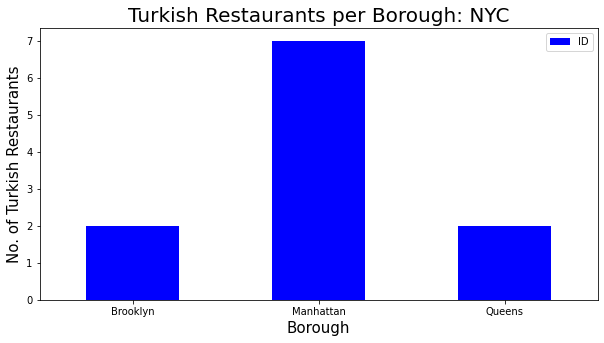

In [14]:
turkish_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Turkish Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Turkish Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

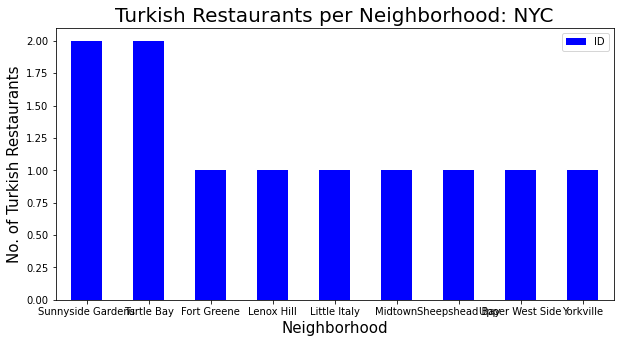

In [22]:
NOofNeigh = 9 # top number 
turkish_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Turkish Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Turkish Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [26]:
turkish_rest_ny[turkish_rest_ny['Neighborhood']=='Sunnyside Gardens']

,Borough,Neighborhood,ID,Name
9,Queens,Sunnyside Gardens,4a75dd5af964a52076e11fe3,Mangal Kebab
10,Queens,Sunnyside Gardens,5be8a67ef870fd002c3a27a2,Sofra Mediterranean Grill


In [27]:
turkish_rest_ny[turkish_rest_ny['Neighborhood']=='Turtle Bay']

,Borough,Neighborhood,ID,Name
7,Manhattan,Turtle Bay,50fc9a88e4b04cfffaebe2cf,Sip Sak
8,Manhattan,Turtle Bay,4a4c0f4ef964a52004ad1fe3,Ali Baba Turkish Cuisine


In [28]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
turkish_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in turkish_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        
        # we will assign 0 value for these resturants as they may have been recently opened or details does not exist in FourSquare Database
        
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(turkish_rest_ny),')','processed')
    turkish_rest_stats_ny = turkish_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
turkish_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '601afc11dde8587529a70769'}, 'response': {'venue': {'id': '4fcbfc92e4b088c92e7e97ad', 'name': 'Opera Cafe Lounge', 'contact': {'phone': '7186762992', 'formattedPhone': '(718) 676-2992', 'twitter': 'operacafeny'}, 'location': {'address': '2255 Emmons Ave', 'crossStreet': 'Dooley', 'lat': 40.58384173638549, 'lng': -73.94448064550176, 'labeledLatLngs': [{'label': 'display', 'lat': 40.58384173638549, 'lng': -73.94448064550176}, {'label': 'entrance', 'lat': 40.583854, 'lng': -73.944621}], 'postalCode': '11235', 'cc': 'US', 'neighborhood': 'Sheepshead Bay', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2255 Emmons Ave (Dooley)', 'Brooklyn, NY 11235', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/opera-cafe-lounge/4fcbfc92e4b088c92e7e97ad', 'categories': [{'id': '4f04af1f2fb6e1c99f3db0bb', 'name': 'Turkish Restaurant', 'pluralName': 'Turkish Restaurants', 'shortName': 'Turkish', 'icon': {'prefix': 'https

{'meta': {'code': 200, 'requestId': '601afc121cd156130c61d578'}, 'response': {'venue': {'id': '4a947f02f964a520ce2120e3', 'name': 'Deniz', 'contact': {'phone': '7188526503', 'formattedPhone': '(718) 852-6503'}, 'location': {'address': '662 Fulton St', 'crossStreet': 'at S Elliott Pl', 'lat': 40.68680227698253, 'lng': -73.97556515066572, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68680227698253, 'lng': -73.97556515066572}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['662 Fulton St (at S Elliott Pl)', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/deniz/4a947f02f964a520ce2120e3', 'categories': [{'id': '4f04af1f2fb6e1c99f3db0bb', 'name': 'Turkish Restaurant', 'pluralName': 'Turkish Restaurants', 'shortName': 'Turkish', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/turkish_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d115941735', 'name': 

{'meta': {'code': 200, 'requestId': '601afc124ecc7d2d3e0e82bf'}, 'response': {'venue': {'id': '598085d9ee628b12e387482a', 'name': 'Sumela Mediterranean Cafe & Grill', 'contact': {'phone': '2128793839', 'formattedPhone': '(212) 879-3839'}, 'location': {'address': '1606 1st Ave', 'crossStreet': 'btwn E 83th & E 84th St', 'lat': 40.77511653246908, 'lng': -73.95064219716679, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77511653246908, 'lng': -73.95064219716679}], 'postalCode': '10028', 'cc': 'US', 'neighborhood': 'Yorkville', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1606 1st Ave (btwn E 83th & E 84th St)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sumela-mediterranean-cafe--grill/598085d9ee628b12e387482a', 'categories': [{'id': '4f04af1f2fb6e1c99f3db0bb', 'name': 'Turkish Restaurant', 'pluralName': 'Turkish Restaurants', 'shortName': 'Turkish', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v

{'meta': {'code': 200, 'requestId': '601afc12f6cb9000caccc940'}, 'response': {'venue': {'id': '4ba41023f964a520807d38e3', 'name': 'A La Turka', 'contact': {'phone': '2127442424', 'formattedPhone': '(212) 744-2424', 'twitter': 'alaturkarestaurant'}, 'location': {'address': '1417 2nd Ave', 'lat': 40.770127907296214, 'lng': -73.9574354558078, 'labeledLatLngs': [{'label': 'display', 'lat': 40.770127907296214, 'lng': -73.9574354558078}], 'postalCode': '10021', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1417 2nd Ave', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/a-la-turka/4ba41023f964a520807d38e3', 'categories': [{'id': '4f04af1f2fb6e1c99f3db0bb', 'name': 'Turkish Restaurant', 'pluralName': 'Turkish Restaurants', 'shortName': 'Turkish', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/turkish_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 40}, 'url': 

{'meta': {'code': 200, 'requestId': '601afc13cb94ee28e9169eb4'}, 'response': {'venue': {'id': '479309d9f964a520564d1fe3', 'name': 'Bodrum Mediterranean Restaurant', 'contact': {'phone': '2127992806', 'formattedPhone': '(212) 799-2806', 'twitter': 'bodrumny', 'facebook': '131044510501', 'facebookUsername': 'bodrumnyc', 'facebookName': 'Bodrum Mediterranean Restaurant'}, 'location': {'address': '584 Amsterdam Ave', 'crossStreet': 'at W 88th St', 'lat': 40.78927368532629, 'lng': -73.97382498331747, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78927368532629, 'lng': -73.97382498331747}], 'postalCode': '10024', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['584 Amsterdam Ave (at W 88th St)', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bodrum-mediterranean-restaurant/479309d9f964a520564d1fe3', 'categories': [{'id': '4f04af1f2fb6e1c99f3db0bb', 'name': 'Turkish Restaurant', 'pluralName': 'Turkish Rest

{'meta': {'code': 200, 'requestId': '601afc13d775ce36899135bc'}, 'response': {'venue': {'id': '542aa73f498e550c05e178d7', 'name': 'Simit Sarayı', 'contact': {'phone': '2126834100', 'formattedPhone': '(212) 683-4100', 'twitter': 'simitsarayi'}, 'location': {'address': '435 5th Ave', 'crossStreet': 'btwn W 38th & W 39th St', 'lat': 40.751419214399036, 'lng': -73.98233589926285, 'labeledLatLngs': [{'label': 'display', 'lat': 40.751419214399036, 'lng': -73.98233589926285}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['435 5th Ave (btwn W 38th & W 39th St)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/simit-saray%C4%B1/542aa73f498e550c05e178d7', 'categories': [{'id': '4f04af1f2fb6e1c99f3db0bb', 'name': 'Turkish Restaurant', 'pluralName': 'Turkish Restaurants', 'shortName': 'Turkish', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/turkish_', 'suffix': '.png'}, 'p

{'meta': {'code': 200, 'requestId': '601afc14a5b9891bca171897'}, 'response': {'venue': {'id': '5008a087e4b034274e2743d8', 'name': 'Little Rascal', 'contact': {'phone': '2129660446', 'formattedPhone': '(212) 966-0446', 'instagram': 'littlerascalbar', 'facebook': '407053726022160', 'facebookUsername': 'littlerascalnyc', 'facebookName': 'Little Rascal'}, 'location': {'address': '163 Elizabeth St', 'crossStreet': 'at Kenmare St', 'lat': 40.72078334747492, 'lng': -73.99501380305635, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72078334747492, 'lng': -73.99501380305635}, {'label': 'entrance', 'lat': 40.720822, 'lng': -73.994984}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['163 Elizabeth St (at Kenmare St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-rascal/5008a087e4b034274e2743d8', 'categories': [{'id': '4f04af1f2fb6e1c99f3db0bb', 'name': 'Turkish Restaurant', 'pl

{'meta': {'code': 200, 'requestId': '601afc14f557fd498bc55852'}, 'response': {'venue': {'id': '50fc9a88e4b04cfffaebe2cf', 'name': 'Sip Sak', 'contact': {'phone': '2125831900', 'formattedPhone': '(212) 583-1900', 'twitter': 'sipsakny'}, 'location': {'address': '928 2nd Ave', 'crossStreet': 'btwn 49th & 50th St', 'lat': 40.75451677439056, 'lng': -73.96884163151609, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75451677439056, 'lng': -73.96884163151609}, {'label': 'entrance', 'lat': 40.754408, 'lng': -73.968664}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['928 2nd Ave (btwn 49th & 50th St)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sip-sak/50fc9a88e4b04cfffaebe2cf', 'categories': [{'id': '4f04af1f2fb6e1c99f3db0bb', 'name': 'Turkish Restaurant', 'pluralName': 'Turkish Restaurants', 'shortName': 'Turkish', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/

{'meta': {'code': 200, 'requestId': '601afc15b20a7c3f0c86b8e2'}, 'response': {'venue': {'id': '4a4c0f4ef964a52004ad1fe3', 'name': 'Ali Baba Turkish Cuisine', 'contact': {'phone': '2128888622', 'formattedPhone': '(212) 888-8622'}, 'location': {'address': '862 2nd Ave', 'crossStreet': 'at 46th St', 'lat': 40.752298251625724, 'lng': -73.97028267882877, 'labeledLatLngs': [{'label': 'display', 'lat': 40.752298251625724, 'lng': -73.97028267882877}], 'postalCode': '10017', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['862 2nd Ave (at 46th St)', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ali-baba-turkish-cuisine/4a4c0f4ef964a52004ad1fe3', 'categories': [{'id': '4f04af1f2fb6e1c99f3db0bb', 'name': 'Turkish Restaurant', 'pluralName': 'Turkish Restaurants', 'shortName': 'Turkish', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/turkish_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d

{'meta': {'code': 200, 'requestId': '601afc15d503a76dd9d9ff92'}, 'response': {'venue': {'id': '4a75dd5af964a52076e11fe3', 'name': 'Mangal Kebab', 'contact': {'phone': '7187060605', 'formattedPhone': '(718) 706-0605'}, 'location': {'address': '4620 Queens Blvd', 'crossStreet': 'at 47th St', 'lat': 40.74278210458195, 'lng': -73.91800428278253, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74278210458195, 'lng': -73.91800428278253}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4620 Queens Blvd (at 47th St)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mangal-kebab/4a75dd5af964a52076e11fe3', 'categories': [{'id': '4f04af1f2fb6e1c99f3db0bb', 'name': 'Turkish Restaurant', 'pluralName': 'Turkish Restaurants', 'shortName': 'Turkish', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/turkish_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'

{'meta': {'code': 200, 'requestId': '601afc1693c98c641bdf81cf'}, 'response': {'venue': {'id': '5be8a67ef870fd002c3a27a2', 'name': 'Sofra Mediterranean Grill', 'contact': {}, 'location': {'address': '45-08 46th St', 'crossStreet': 'Queens Boulevard', 'lat': 40.742461, 'lng': -73.9192, 'labeledLatLngs': [{'label': 'display', 'lat': 40.742461, 'lng': -73.9192}, {'label': 'entrance', 'lat': 40.742377, 'lng': -73.918962}], 'postalCode': '11104', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['45-08 46th St (Queens Boulevard)', 'New York, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sofra-mediterranean-grill/5be8a67ef870fd002c3a27a2', 'categories': [{'id': '4f04af1f2fb6e1c99f3db0bb', 'name': 'Turkish Restaurant', 'pluralName': 'Turkish Restaurants', 'shortName': 'Turkish', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/turkish_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tip

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
6,Manhattan,Little Italy,5008a087e4b034274e2743d8,Little Rascal,205,8.5,66
7,Manhattan,Turtle Bay,50fc9a88e4b04cfffaebe2cf,Sip Sak,283,8.8,99
8,Manhattan,Turtle Bay,4a4c0f4ef964a52004ad1fe3,Ali Baba Turkish Cuisine,82,7.1,39
9,Queens,Sunnyside Gardens,4a75dd5af964a52076e11fe3,Mangal Kebab,68,8.4,37
10,Queens,Sunnyside Gardens,5be8a67ef870fd002c3a27a2,Sofra Mediterranean Grill,9,7.6,3


In [29]:
turkish_rest_stats_ny.to_csv('japanese_rest_stats_ny_csv.csv') 

In [30]:
turkish_rest_stats_ny.shape

(11, 7)

In [31]:
turkish_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       11 non-null     object 
 1   Neighborhood  11 non-null     object 
 2   ID            11 non-null     object 
 3   Name          11 non-null     object 
 4   Likes         11 non-null     object 
 5   Rating        11 non-null     float64
 6   Tips          11 non-null     object 
dtypes: float64(1), object(6)
memory usage: 744.0+ bytes


In [32]:
turkish_rest_stats_ny['Likes'] = turkish_rest_stats_ny['Likes'].astype('float64')
turkish_rest_stats_ny['Tips'] = turkish_rest_stats_ny['Tips'].astype('float64')
turkish_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       11 non-null     object 
 1   Neighborhood  11 non-null     object 
 2   ID            11 non-null     object 
 3   Name          11 non-null     object 
 4   Likes         11 non-null     float64
 5   Rating        11 non-null     float64
 6   Tips          11 non-null     float64
dtypes: float64(3), object(4)
memory usage: 744.0+ bytes


In [33]:
turkish_rest_stats_ny.describe()

,Likes,Rating,Tips
count,11.000000,11.000000,11.000000
mean,163.636364,7.963636,52.545455
std,169.561949,0.574931,40.601388
min,9.000000,7.000000,3.000000
25%,63.500000,7.600000,38.000000
50%,105.000000,8.100000,43.000000
75%,231.500000,8.350000,60.000000
max,592.000000,8.800000,145.000000


In [34]:
# Resturant with maximum Likes
turkish_rest_stats_ny.iloc[turkish_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              542aa73f498e550c05e178d7
Name                        Simit Sarayı
Likes                                592
Rating                               8.2
Tips                                 145
Name: 5, dtype: object

In [35]:
# Resturant with maximum Ratings
turkish_rest_stats_ny.iloc[turkish_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                  Turtle Bay
ID              50fc9a88e4b04cfffaebe2cf
Name                             Sip Sak
Likes                                283
Rating                               8.8
Tips                                  99
Name: 7, dtype: object

In [36]:
# Resturant with maximum Tips
turkish_rest_stats_ny.iloc[turkish_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              542aa73f498e550c05e178d7
Name                        Simit Sarayı
Likes                                592
Rating                               8.2
Tips                                 145
Name: 5, dtype: object

In [37]:
# Now let's identify and visualize neighborhood with the maximum average rating of restaurants

In [38]:
ny_neighborhood_stats=turkish_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
2,Little Italy,8.50
4,Sheepshead Bay,8.30
3,Midtown,8.20
1,Lenox Hill,8.10
5,Sunnyside Gardens,8.00
7,Upper West Side,8.00
6,Turtle Bay,7.95
0,Fort Greene,7.60
8,Yorkville,7.00


In [39]:
# Average ratings of Turkish Restaurants for each Borough

ny_borough_stats=turkish_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Queens,8.000000
1,Manhattan,7.957143
0,Brooklyn,7.950000


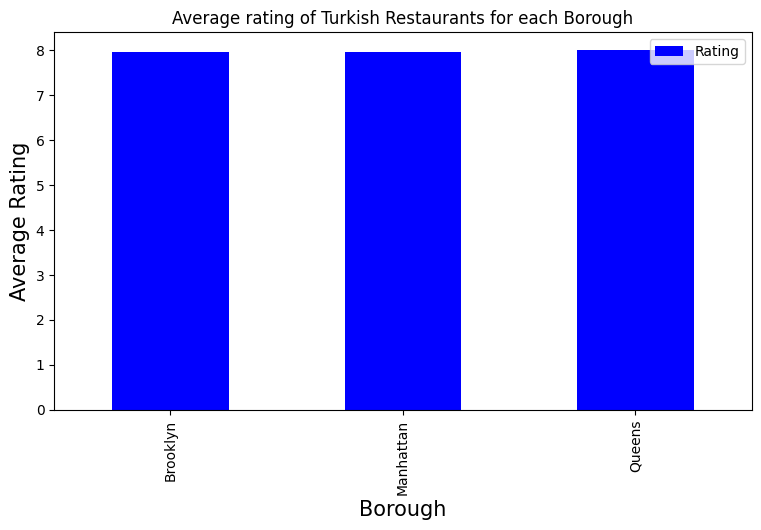

In [41]:
# Let's visualize the results

plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Turkish Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
turkish_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [42]:
# We will consider all the neighborhoods with average rating greater or equal 8.0 to visualize on a map

ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
1,Lenox Hill,8.1
2,Little Italy,8.5
3,Midtown,8.2
4,Sheepshead Bay,8.3
5,Sunnyside Gardens,8.0
7,Upper West Side,8.0


In [43]:
# We will join this Dataset to original New York data to get longitude and latitude

ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Lenox Hill,40.768113,-73.958860,8.1
1,Manhattan,Little Italy,40.719324,-73.997305,8.5
2,Manhattan,Midtown,40.754691,-73.981669,8.2
3,Brooklyn,Sheepshead Bay,40.586890,-73.943186,8.3
4,Queens,Sunnyside Gardens,40.745652,-73.918193,8.0
5,Manhattan,Upper West Side,40.787658,-73.977059,8.0


In [44]:
# Now we will show this data on a map

# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [45]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

### Results / Conclusion  

As we can clearly see that Boroughs of Brooklyn and Bronx are perfect locations to open a Turkish restaurant. This analysis is based on the accuracy of Four Square data of course. 

Even though Boroughs on Manhattan and Queens have Turkish restaurants, there still aren't enough and with the high rating and likes it is only justified that we see more Turkish restaurants in those boroughs as well.

I will debate that real-estate rents in Manhattan in the post pandemic era will be comptetitive and not as exorbitant as it used to be prior to 2020. Most people now telecommute and if anything, the commercial rent in residential araes such as Bronx, Queen, and Brooklyn would see a spike as opposed to Manhattan which is mainly office buildings.

With a significant amount of immigrants from Turey and other countries surrounding the mediterranean, New York has relatively small number of Turkish restaurants, we definitely need to see that number rise.  